# Australian Fashion Data

<!-- Full-width clickable image -->
<a href="https://www.nvidia.com/en-us/training/" target="_blank">
  <img src="https://mlrwd9rnffxq.i.optimole.com/cb:641c.2be21/w:1024/h:724/q:90/f:best/sm:0/https://vectorize.io/wp-content/uploads/2024/09/Agentic-RAG-1.png"
       style="width: 100%; height: auto; display: block; margin-top: 30px;" 
       alt="Agentic RAG Workflow">
</a>

<!-- Headings below -->
<h1 style="line-height: 1.4; color: #76b900;"><b>Building RAG Workflows with LLMs</b></h1>
<h2><b>Assessment:</b> Understanding a RAG Agent</h2>


# SETUP, GATHER RAG TOOLS, & LOAD THE DATA

In [ ]:
print("Installing necessary libraries...")
!pip install -q langchain langchain-openai openai chromadb gradio python-dotenv tiktoken langchain-community
print("Libraries installed successfully!")

Installing necessary libraries...
Libraries installed successfully!


In [2]:
# Let's install and import OpenAI Package
!pip install --upgrade openai
from openai import OpenAI  

# Let's import os, which stands for "Operating System"
import os

# This will be used to load the API key from the .env file
from dotenv import load_dotenv
load_dotenv()

# Get the OpenAI API keys from environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")

# Let's configure the OpenAI Client using our key
openai_client = OpenAI(api_key=openai_api_key)
print("OpenAI client successfully configured.")

# Let's view the first few characters in the key
print(openai_api_key[:15])

OpenAI client successfully configured.
sk-proj-X3RRj9v


In [3]:
# Let's import Langchain components
from langchain_openai import OpenAIEmbeddings, OpenAI
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQAWithSourcesChain 

In [4]:
# Define the path to your data file
# Ensure 'eleven_madison_park_data.txt' is in the same folder as this notebook
DATA_FILE_PATH = "cars_info.csv"
print(f"Data file path set to: {DATA_FILE_PATH}")

Data file path set to: cars_info.csv


In [5]:
# Let's load Eleven Madison Park Restaurant data, which has been scraped from their website
# The data is saved in "eleven_madison_park_data.txt", Langchain's TextLoader makes this easy to read
print(f"Attempting to load data from: {DATA_FILE_PATH}")

# Initialize the TextLoader with the file path and specify UTF-8 encoding
# Encoding helps handle various characters correctly
loader = TextLoader(DATA_FILE_PATH, encoding = "utf-8")

# Load the document(s) using TextLoader from LangChain, which loads the entire file as one Document object
raw_documents = loader.load()
print(f"Successfully loaded {len(raw_documents)} document(s).")


Attempting to load data from: cars_info.csv
Successfully loaded 1 document(s).


In [6]:
# Let's display a few characters of the loaded content to perform a sanity check!
print(raw_documents[0].page_content[:500] + "...")

ID,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Color,Seating Capacity
11530130,2010 Toyota Rukus Build 2 AZE151R,9999,Toyota,Rukus,Build 2,AZE151R,2010,263000,Wagon,Automatic,Unleaded Petrol, Used,2362,Grey,5
12190570,2021 Mercedes-Benz V 250 D Avantgarde MWB 447 MY21,117990,Mercedes-Benz,V,250 D Avantgarde MWB,447 MY21,2021,19,Wagon,Automatic,Diesel, New In Stock,2143,Black,7
12321855,2021 Mercedes-Benz Valente 116 CDI MWB RWD 447 MY21,79990,Mercedes-Benz,V...


In [7]:
print(raw_documents[0].page_content[:500])

ID,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Color,Seating Capacity
11530130,2010 Toyota Rukus Build 2 AZE151R,9999,Toyota,Rukus,Build 2,AZE151R,2010,263000,Wagon,Automatic,Unleaded Petrol, Used,2362,Grey,5
12190570,2021 Mercedes-Benz V 250 D Avantgarde MWB 447 MY21,117990,Mercedes-Benz,V,250 D Avantgarde MWB,447 MY21,2021,19,Wagon,Automatic,Diesel, New In Stock,2143,Black,7
12321855,2021 Mercedes-Benz Valente 116 CDI MWB RWD 447 MY21,79990,Mercedes-Benz,V


# SPLITTING DOCUMENTS (CHUNKING) WITH LANGCHAIN TEXT SPLITTER

Large documents are hard for AI models to process efficiently and make it difficult to find specific answers. We need to split the loaded document into smaller, manageable "chunks". We'll use Langchain's `RecursiveCharacterTextSplitter`.

*   **Why chunk?** Smaller pieces are easier to embed, store, and retrieve accurately.
*   **`chunk_size`**: Max characters per chunk.
*   **`chunk_overlap`**: Characters shared between consecutive chunks (helps maintain context).

In [8]:
# Let's split the document into chunks
print("\nSplitting the loaded document into smaller chunks...")

# Let's initialize the splitter, which tries to split the document on common separators like paragraphs (\n\n),
# sentences (.), and spaces (' ').
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000,  # Aim for chunks of about 1000 characters
                                               chunk_overlap = 150,)  # Each chunk overlaps with the previous by 150 characters

# Split the raw document(s) into smaller Document objects (chunks)
documents = text_splitter.split_documents(raw_documents)

# Check if splitting produced any documents
if not documents:
    raise ValueError("Error: Splitting resulted in zero documents. Check the input file and splitter settings.")
print(f"Document split into {len(documents)} chunks.")



Splitting the loaded document into smaller chunks...
Document split into 3036 chunks.


In [9]:
# Let's display the Python list containing document chunks 
documents

[Document(metadata={'source': 'cars_info.csv'}, page_content='ID,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Color,Seating Capacity\n11530130,2010 Toyota Rukus Build 2 AZE151R,9999,Toyota,Rukus,Build 2,AZE151R,2010,263000,Wagon,Automatic,Unleaded Petrol, Used,2362,Grey,5\n12190570,2021 Mercedes-Benz V 250 D Avantgarde MWB 447 MY21,117990,Mercedes-Benz,V,250 D Avantgarde MWB,447 MY21,2021,19,Wagon,Automatic,Diesel, New In Stock,2143,Black,7\n12321855,2021 Mercedes-Benz Valente 116 CDI MWB RWD 447 MY21,79990,Mercedes-Benz,Valente,116 CDI MWB RWD,447 MY21,2021,24,Wagon,Automatic,Diesel, New In Stock,2143,Black,8\n12346971,2010 Mercedes-Benz E250 CDI Avantgarde 207,34990,Mercedes-Benz,E250,CDI Avantgarde,207,2010,120579,Cabriolet,Automatic,Diesel, Used,2143,Black,4\n12363884,2016 Holden Cruze CD JH MY16,15990,Holden,Cruze,CD,JH MY16,2016,72506,Sportswagon,Automatic,Unleaded Petrol, Used,1796,White,5'),
 Document(metadata={'source': 'cars_info.csv'}, pa

In [10]:
# Let's display an example chunk and its metadata
print("\n--- Example Chunk (Chunk 2) ---")
print(documents[2].page_content)
print("\n--- Metadata for Chunk 2 ---")
print(documents[2].metadata) # Should show {'source': 'eleven_madison_park_data.txt'}


--- Example Chunk (Chunk 2) ---
12382946,2003 Holden Commodore Berlina Vyii,15490,Holden,Commodore,Berlina,Vyii,2003,186990,Sedan,Automatic,Unleaded Petrol, Used,5665,Green,5
12382955,2015 Isuzu D-MAX SX (4X2) TF MY15,15490,Isuzu,D-MAX,SX (4X2),TF MY15,2015,231907,Cab Chassis,Manual,Diesel, Used,2999,White,2
12382958,2013 Ford Focus Ambiente LW MK2,12490,Ford,Focus,Ambiente,LW MK2,2013,64109,Hatchback,Manual,Unleaded Petrol, Used,1596,Black,5
12403536,2013 Hyundai Elantra Active MD2,13500,Hyundai,Elantra,Active,MD2,2013,84500,Sedan,Automatic,Unleaded Petrol, Used,1796,WHITE,5
12405893,2020 Hyundai Santa FE Active MPI (2WD) TM.2 MY20,39880,Hyundai,Santa FE,Active MPI (2WD),TM.2 MY20,2020,57683,Wagon,Automatic,Unleaded Petrol, Used,3470,White,7
12410238,2010 Hyundai I30 SX FD MY10,10500,Hyundai,I30,SX,FD MY10,2010,87318,Hatchback,Automatic,Unleaded Petrol, Used,1591,Blue,5
12420343,2015 Volkswagen Caddy Maxi TDI250 2K MY15,27490,Volkswagen,Caddy,Maxi TDI250,2K MY15,2015,137423,Van,Autom

# EMBEDDINGS AND VECTOR STORE CREATION 


Now, we convert our text chunks into **embeddings** (numerical vectors) using OpenAI. Similar text chunks will have similar vectors. We then store these vectors in a **vector store** (ChromaDB) for fast searching.

*   **Embeddings:** Text -> Numbers (Vectors) representing meaning.
*   **Vector Store:** Database optimized for searching these vectors.

Tensorflow Ebeddings projector (it's fun!): https://projector.tensorflow.org/

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

print("Initializing OpenAI Embeddings model...")

# Create OpenAI Embedding instance
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)
print("OpenAI Embeddings model initialized.")

# Split documents into safe-sized chunks
print("\nSplitting documents to prevent token overflow...")
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
split_documents = text_splitter.split_documents(documents)

# Create ChromaDB vector store
print("\nCreating ChromaDB vector store and embedding documents...")
vector_store = Chroma.from_documents(
    documents=split_documents,
    embedding=embeddings
)

# Verify the number of items in the store
vector_count = vector_store._collection.count()
print(f"ChromaDB vector store created with {vector_count} items.")

if vector_count == 0:
    raise ValueError("Vector store creation resulted in 0 items. Check previous steps.")


/var/folders/77/g7mpc8mx54j9qfsl3n4sty2w0000gn/T/ipykernel_7720/1735849657.py:8: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Initializing OpenAI Embeddings model...
OpenAI Embeddings model initialized.

Splitting documents to prevent token overflow...

Creating ChromaDB vector store and embedding documents...
ChromaDB vector store created with 6806 items.


In [13]:
# Let's retrieve the first chunk of stored data from the vector store
stored_data = vector_store._collection.get(include=["embeddings", "documents"], limit = 1)  

# Display the results
print("First chunk text:\n", stored_data['documents'][0])
print("\nEmbedding vector:\n", stored_data['embeddings'][0])
print(f"\nFull embedding has {len(stored_data['embeddings'][0])} dimensions.")

Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given


First chunk text:
 ID,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Color,Seating Capacity
11530130,2010 Toyota Rukus Build 2 AZE151R,9999,Toyota,Rukus,Build 2,AZE151R,2010,263000,Wagon,Automatic,Unleaded Petrol, Used,2362,Grey,5
12190570,2021 Mercedes-Benz V 250 D Avantgarde MWB 447 MY21,117990,Mercedes-Benz,V,250 D Avantgarde MWB,447 MY21,2021,19,Wagon,Automatic,Diesel, New In Stock,2143,Black,7

Embedding vector:
 [ 0.01167287 -0.00551034  0.00728723 ... -0.00607934 -0.01892682
 -0.03657588]

Full embedding has 1536 dimensions.


**PRACTICE OPPORTUNITY:**
- **Using Tensorflow Embeddings Projector, explore the nearest points to "Italy"**
- **Choose 2 additional different words that you like**
- **Tensorflow Ebeddings projector: https://projector.tensorflow.org/**

# TESTING THE RETRIEVAL

Before building the full Q&A chain, let's test if our vector store can find relevant chunks based on a sample question. We'll use the `similarity_search` method.


In [14]:
# Let's perform a similarity search in our vector store
print("\n--- Testing Similarity Search in Vector Store ---")
test_query = "What different menus are offered?"
print(f"Searching for documents similar to: '{test_query}'")


# Perform a similarity search. 'k=2' retrieves the top 2 most similar chunks
try:
    similar_docs = vector_store.similarity_search(test_query, k = 2)
    print(f"\nFound {len(similar_docs)} similar documents:")

    # Display snippets of the retrieved documents and their sources
    for i, doc in enumerate(similar_docs):
        print(f"\n--- Document {i+1} ---")
        # Displaying the first 700 chars for brevity
        content_snippet = doc.page_content[:700].strip() + "..."
        source = doc.metadata.get("source", "Unknown Source")  # Get source from metadata
        print(f"Content Snippet: {content_snippet}")
        print(f"Source: {source}")

except Exception as e:
    print(f"An error occurred during similarity search: {e}")




--- Testing Similarity Search in Vector Store ---
Searching for documents similar to: 'What different menus are offered?'


Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given



Found 2 similar documents:

--- Document 1 ---
Content Snippet: 12817459,2015 Holden Barina CD TM MY15,7999,Holden,Barina,CD,TM MY15,2015,125439,Hatchback,Manual,Unleaded Petrol, Used,1598,White,5
12817460,2014 Nissan Navara RX (4X4) D40 MY13,15990,Nissan,Navara,RX (4X4),D40 MY13,2014,176363,Cab Chassis,Manual,Diesel, Used,2488,White,3
12817462,2007 Mazda 3 SP23 BK MY06 Upgrade,4950,Mazda,3,SP23,BK MY06 Upgrade,2007,219657,Sedan,Manual,Unleaded Petrol, Used,2261,Blue,5...
Source: cars_info.csv

--- Document 2 ---
Content Snippet: 12831135,2017 Holden Barina LS TM MY17,13888,Holden,Barina,LS,TM MY17,2017,75222,Hatchback,Automatic,Premium Unleaded Petrol, Used,1598,Grey,5
12831159,2018 Ford Mustang Fastback GT 5.0 V8 FN,64990,Ford,Mustang,Fastback GT 5.0 V8,FN,2018,20001,Coupe,Automatic,Premium Unleaded Petrol, Used,4950,Black,4
12831161,2016 Infiniti QX80 S Premium Z62,58000,Infiniti,QX80,S Premium,Z62,2016,170105,Wagon,Automatic,Premium Unleaded Petrol, Used,5552,Black,8...
Source: ca

# BUILDING & TESTING THE RAG CHAIN USING LANGCHAIN


Now we assemble the core RAG logic using Langchain's `RetrievalQAWithSourcesChain`. This chain combines:
1.  A **Retriever**: Fetches relevant documents from our `vector_store`.
2.  An **LLM**: Generates the answer based on the question and retrieved documents (we'll use OpenAI).

This specific chain type automatically handles retrieving documents, formatting them with the question for the LLM, and tracking the sources.


In [15]:
# --- 1. Define the Retriever ---
# The retriever uses the vector store to fetch documents
# We configure it to retrieve the top 'k' documents
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
print("Retriever configured successfully from vector store.")

# --- 2. Define the Language Model (LLM) from OpenAI---
# Temperature controls the model's creativity; 'temperature=0' aims for more factual, less creative answers
# You might need to specify a more powerful model, such as "gpt-3.5-turbo-instruct"
llm = OpenAI(temperature = 1.3, openai_api_key = openai_api_key)
print("OpenAI LLM successfully initialized.")

# --- 3. Create the RetrievalQAWithSourcesChain ---
# This chain type is designed specifically for Q&A with source tracking.
# chain_type="stuff": Puts all retrieved text directly into the prompt context.
#                      Suitable if the total text fits within the LLM's context limit.
#                      Other types like "map_reduce" handle larger amounts of text.
qa_chain = RetrievalQAWithSourcesChain.from_chain_type(llm = llm,
                                                       chain_type = "stuff",
                                                       retriever = retriever,
                                                       return_source_documents = True,  # Request the actual Document objects used
                                                       verbose = True)  # Set to True to see Langchain's internal steps (can be noisy)

print("RetrievalQAWithSourcesChain created")

Retriever configured successfully from vector store.
OpenAI LLM successfully initialized.
RetrievalQAWithSourcesChain created


In [18]:
# --- Test the Full Chain ---
print("\n--- Testing the Full RAG Chain ---")
chain_test_query = "what is 2010 Toyota Rukus Build ?"
print(f"Query: {chain_test_query}")

# Run the query through the chain. Use invoke() for Langchain >= 0.1.0
# The input must be a dictionary, often with the key 'question'.
try:
    result = qa_chain.invoke({"question": chain_test_query})

    # Print the answer and sources from the result dictionary
    print("\n--- Answer ---")
    print(result.get("answer", "No answer generated."))

    print("\n--- Sources ---")
    print(result.get("sources", "No sources identified."))

    # Optionally print snippets from the source documents returned
    if "source_documents" in result:
        print("\n--- Source Document Snippets ---")
        for i, doc in enumerate(result["source_documents"]):
            content_snippet = doc.page_content[:250].strip()
            print(f"Doc {i+1}: {content_snippet}")

except Exception as e:
    print(f"\nAn error occurred while running the chain: {e}")
    # Consider adding more specific error handling if needed


--- Testing the Full RAG Chain ---
Query: what is 2010 Toyota Rukus Build ?


> Entering new RetrievalQAWithSourcesChain chain...

> Finished chain.

--- Answer ---
 The 2010 Toyota Rukus Build 2 AZE151R is a wagon car with an automatic gearbox and 2362 cc engine size, costing $18,484.<br>


--- Sources ---
cars_info.csv

--- Source Document Snippets ---
Doc 1: 12843430,2010 Toyota Rukus Build 1 AZE151R,12990,Toyota,Rukus,Build 1,AZE151R,2010,193804,Wagon,Automatic,Unleaded Petrol, Used,2362,Silver,5
12843433,2021 Isuzu D-MAX LS-U (4X4) RG MY21,69000,Isuzu,D-MAX,LS-U (4X4),RG MY21,2021,2065,Space Cab Utilit
Doc 2: 12827678,2012 Toyota Rukus Build 2 AZE151R,18484,Toyota,Rukus,Build 2,AZE151R,2012,59477,Wagon,Automatic,Unleaded Petrol, Used,2362,White,5
12827689,2017 Audi Q2 1.4 Tfsi YA COD GA,28990,Audi,Q2,1.4 Tfsi YA COD,GA,2017,128424,Wagon,Automatic,Premium
Doc 3: ID,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Color,Seating Capacity
11530130,201

# CREATING A GRADIO INTERFACE FOR OUR RAG CHAIN

Let's wrap our RAG chain in a user-friendly web interface using Gradio. Users will type a question, click a button, and see the answer along with the sources the AI used.


In [19]:
# Gradio for UI
import gradio as gr

In [21]:
# --- Define the Function for Gradio ---

# This function takes the user's input, runs the chain, and formats the output
# Ensure the `qa_chain` variable is accessible in this scope.
def ask_elevenmadison_assistant(user_query):
    """
    Processes the user query using the RAG chain and returns formatted results.
    """
    print(f"\nProcessing Gradio query: '{user_query}'")
    if not user_query or user_query.strip() == "":
        print("--> Empty query received.")
        return "Please enter a question.", ""  # Handle empty input gracefully

    try:
        # Run the query through our RAG chain
        result = qa_chain.invoke({"question": user_query})

        # Extract answer and sources
        answer = result.get("answer", "Sorry, I couldn't find an answer in the provided documents.")
        sources = result.get("sources", "No specific sources identified.")

        # Basic formatting for sources (especially if it just returns the filename)
        if sources == DATA_FILE_PATH:
            sources = f"Retrieved from: {DATA_FILE_PATH}"
        elif isinstance(sources, list):  # Handle potential list of sources
            sources = ", ".join(list(set(sources)))  # Unique, comma-separated

        print(f"--> Answer generated: {answer[:100].strip()}...")
        print(f"--> Sources identified: {sources}")

        # Return the answer and sources to be displayed in Gradio output components
        return answer.strip(), sources

    except Exception as e:
        error_message = f"An error occurred: {e}"
        print(f"--> Error during chain execution: {error_message}")
        # Return error message to the user interface
        return error_message, "Error occurred"


# --- Create the Gradio Interface using Blocks API ---
print("\nSetting up Gradio interface...")

with gr.Blocks(theme=gr.themes.Soft(), title="Australian Car Sales Q&A Assistant") as demo:
    # Title and description for the app
    gr.Markdown(
        """
        # Car Sales - AI Q&A Assistant 💬
        Ask questions about the Car Sales based on its website data.
        The AI provides answers and cites the source document.
        *(Examples: What are the menu prices? Who is the chef? Is it plant-based?)*
        """
    )

    # Input component for the user's question
    question_input = gr.Textbox(
        label = "Your Question:",
        placeholder = "e.g., What are the opening hours on Saturday?",
        lines = 2,  # Allow a bit more space for longer questions
    )

    # Row layout for the output components
    with gr.Row():
        # Output component for the generated answer (read-only)
        answer_output = gr.Textbox(label="Answer:", interactive=False, lines=6)  # User cannot edit this
        # Output component for the sources (read-only)
        sources_output = gr.Textbox(label="Sources:", interactive=False, lines=2)

    # Row for buttons
    with gr.Row():
        # Button to submit the question
        submit_button = gr.Button("Ask Question", variant="primary")
        # Clear button to reset inputs and outputs
        clear_button = gr.ClearButton(components=[question_input, answer_output, sources_output], value="Clear All")

    # Add some example questions for users to try
    gr.Examples(
        examples=[
            "What are the different menu options and prices?",
            "Who is the head chef?",
            "What is Magic Farms?"],
        inputs=question_input,  # Clicking example loads it into this input
        # We could potentially add outputs=[answer_output, sources_output] and cache examples
        # but that requires running the chain for each example beforehand.
        cache_examples=False,  # Don't pre-compute results for examples for simplicity
    )

    # --- Connect the Submit Button to the Function ---
    # When submit_button is clicked, call 'ask_emp_assistant'
    # Pass the value from 'question_input' as input
    # Put the returned values into 'answer_output' and 'sources_output' respectively
    submit_button.click(fn = ask_elevenmadison_assistant, inputs = question_input, outputs = [answer_output, sources_output])

print("Gradio interface defined.")

# --- Launch the Gradio App ---
print("\nLaunching Gradio app... (Stop the kernel or press Ctrl+C in terminal to quit)")
# demo.launch() # Launch locally in the notebook or browser
demo.launch()  


Setting up Gradio interface...
Gradio interface defined.

Launching Gradio app... (Stop the kernel or press Ctrl+C in terminal to quit)
* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


**PRACTICE OPPORTUNITY:**
- **Expand on the example questions to include the ones below. Rerun the app and test them out.**
    - **"Do I need a reservation for the bar?"**
    - **"What is the dress code?**
    - **"Can I buy gift cards?"**
- **Change the text on the submit button from `Ask Question` to `Ask Eleven Madison Park AI 🤖`. Where do you make this change?**
- **We already added a `gr.ClearButton` in the code above. Test it out! Ask a question, get an answer, then click the "Clear All" button. Does it clear the question, answer, and sources fields?**

# PRACTICE OPPORTUNITY SOLUTIONS

**PRACTICE OPPORTUNITY SOLUTION:** 
- **Display the last 750 characters in the loaded document**
- **Perform a sanity check by comparing the printed characters to `eleven_madison_park_data.txt` file**
- **Print the email and the phone number of the restaurant**

In [ ]:
# Let's display the last characters of the loaded content
print(raw_documents[0].page_content[-750:] + "...")

**PRACTICE OPPORTUNITY SOLUTION:**
- **Change `chunk_size` to `500` in the `RecursiveCharacterTextSplitter` and re-run the cell. How many chunks do you get now? Is it more or less than before? Change it back to `1000`**
- **Change `chunk_overlap` to `0` and re-run the cell. Does the number of chunks change drastically? What problem might setting overlap to 0 cause? Change it back to `150`**
- **Print the last example chunk and its metadata and re-run the cell. What information is stored in the `metadata`? Why is the `'source'` important?**

In [ ]:
# Let's display an example chunk and its metadata
print("\n--- Example Chunk (Last Chunk) ---")
print(documents[-1].page_content)
print("\n--- Metadata for Last Chunk---")
print(documents[-1].metadata)

1. Changing `chunk_size=500` will result in *more* chunks being created because the original document is being divided into smaller pieces. The exact number depends on the total text length and overlap.
2. Changing `chunk_overlap=0` might slightly change the total number of chunks, but usually not by a large amount compared to changing the chunk size. The potential problem with zero overlap is that if an important sentence or idea happens to fall exactly on the boundary between two chunks, it might get cut in half, and the full context could be lost in both resulting chunks. Overlap mitigates this by ensuring some context is repeated.
3. The `'source'` key is crucial because it links the chunk back to its origin file, allowing the RAG chain to later report this source when providing citations for its answer.

**PRACTICE OPPORTUNITY SOLUTION:**
- **Using Tensorflow Embeddings Projector, explore the nearest points to "Italy"**
- **Choose 2 additional different words that you like**
- **Tensorflow Ebeddings projector: https://projector.tensorflow.org/**

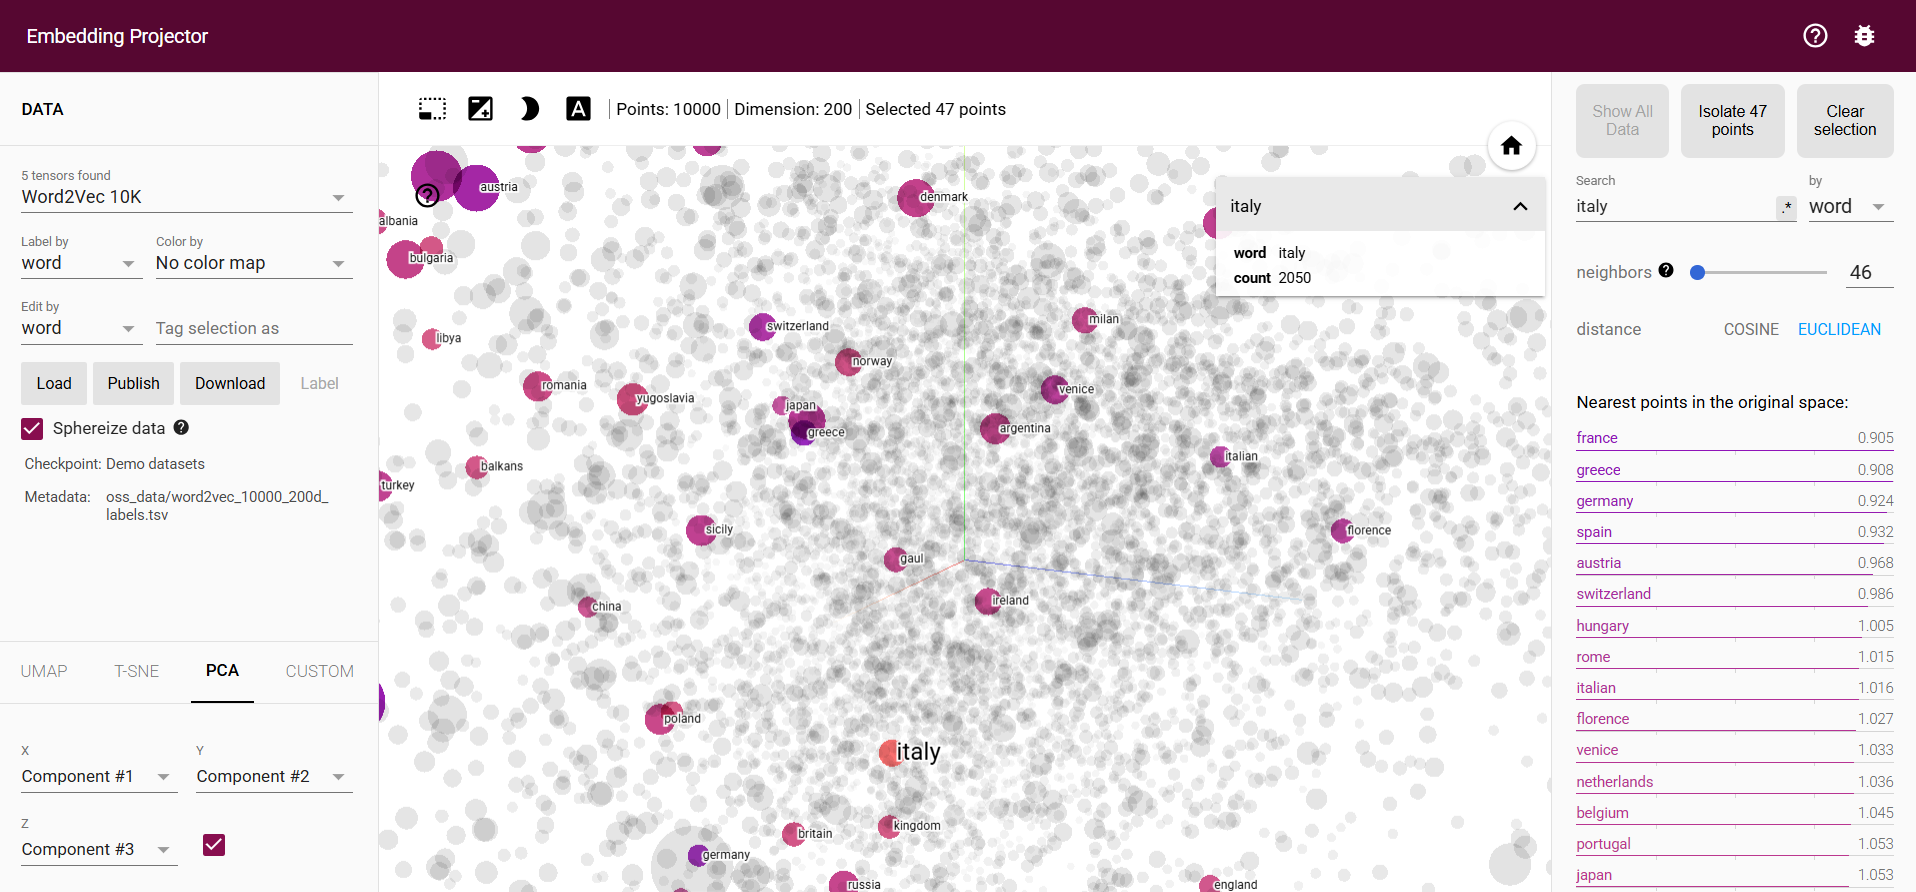

**PRACTICE OPPORTUNITY SOLUTION:**
- **Change the `test_query` variable to ask one of the following questions. Re-run the cell for each question. Do the retrieved document snippets seem relevant to your question?**
    - `"Who is Daniel Humm?"`
    - `"Is there a dress code?"`
    - `"Tell me about the partnership with Magic Farms."`
    - `"How do I make a reservation?"`
- **Adjust the value of k to `k=1` and then to `k=5`. Re-run the cell. How does changing `k` affect the number of documents retrieved?**

In [ ]:
# Let's perform a similarity search in our vector store
print("\n--- Testing Similarity Search in Vector Store ---")
test_query = "Tell me about the partnership with Magic Farms."
print(f"Searching for documents similar to: '{test_query}'")


# Perform a similarity search. 'k=2' retrieves the top 3 most similar chunks
try:
    similar_docs = vector_store.similarity_search(test_query, k = 1)
    print(f"\nFound {len(similar_docs)} similar documents:")

    # Display snippets of the retrieved documents and their sources
    for i, doc in enumerate(similar_docs):
        print(f"\n--- Document {i+1} ---")
        # Displaying the first 700 chars for brevity
        content_snippet = doc.page_content[:700].strip() + "..."
        source = doc.metadata.get("source", "Unknown Source")  # Get source from metadata
        print(f"Content Snippet: {content_snippet}")
        print(f"Source: {source}")

except Exception as e:
    print(f"An error occurred during similarity search: {e}")


**PRACTICE OPPORTUNITY SOLUTION:**
- **Look at the `result` dictionary printed by the chain test. What are the key pieces of information it contains?**
- **Change `temperature=0` to `temperature=1.3` in the `llm = OpenAI(...)` line. Re-run the cell and ask the *same* `chain_test_query`. Does the wording of the answer change slightly? Change it back to `0`.**
- **Set `verbose=True` and `return_source_documents=True` in the `RetrievalQAWithSourcesChain.from_chain_type(...)` line. Re-run the cell. What extra information do you see printed? Set it back to `False`.**


In [54]:
result

{'question': 'What kind of food does Eleven Madison Park serve?',
 'answer': ' Eleven Madison Park serves a discounted plant-based menu and farm-sourced à la carte snacks, reservations are required.\n',
 'sources': 'https://www.elevenmadisonpark.com/faq',
 'source_documents': [Document(metadata={'source': 'eleven_madison_park_data.txt'}, page_content='Welcome to Eleven Madison Park Eleven Madison Park is a fine dining restaurant in the heart of New York City. Overlooking Madison Square Park–one of Manhattan’s most beautiful green spaces–we sit at the base of a historic Art Deco building on the corner of East 24th Street and Madison Avenue. Since opening in 1998, we underwent a full-scale renovation and redesign in the summer of 2017. Chef Daniel Humm has owned the restaurant since 2011, during which time we have evolved considerably in both cuisine and experience. In 2021, we transitioned to a fully plant-based menu, using no animal products. That same year, we partnered with Magic Far

1.  **Chain Output:** The `result` dictionary from `RetrievalQAWithSourcesChain` typically contains:
    *   `'question'`: The original input question.
    *   `'answer'`: The textual answer generated by the LLM based on the retrieved context.
    *   `'sources'`: A string listing the source(s) identified (often the filename from the metadata of the used documents).
    *   `'source_documents'`: If `return_source_documents=True`, this key holds a list of the actual Langchain `Document` objects that were retrieved and passed to the LLM.
2.  **Temperature Effect:** Changing `temperature=1.3` introduces more randomness into the LLM's generation process. While the answer should still be based on the retrieved context, the exact phrasing, sentence structure, or choice of words might vary slightly each time you run the query, compared to the more deterministic output with `temperature=0`.
3.  **Verbose Mode:** Setting `verbose=True` causes Langchain to print detailed internal logs. 

**PRACTICE OPPORTUNITY SOLUTION:**
- **Expand on the example questions to include the ones below. Rerun the app and test them out.**
    - **"Do I need a reservation for the bar?"**
    - **"What is the dress code?**
    - **"Can I buy gift cards?"**
- **Change the text on the submit button from `Ask Question` to `Ask Eleven Madison Park AI 🤖`. Where do you make this change?**
- **We already added a `gr.ClearButton` in the code above. Test it out! Ask a question, get an answer, then click the "Clear All" button. Does it clear the question, answer, and sources fields?**

In [65]:
# --- Define the Function for Gradio ---

# This function takes the user's input, runs the chain, and formats the output
# Ensure the `qa_chain` variable is accessible in this scope.
def ask_elevenmadison_assistant(user_query):
    """
    Processes the user query using the RAG chain and returns formatted results.
    """
    print(f"\nProcessing Gradio query: '{user_query}'")
    if not user_query or user_query.strip() == "":
        print("--> Empty query received.")
        return "Please enter a question.", ""  # Handle empty input gracefully

    try:
        # Run the query through our RAG chain
        result = qa_chain.invoke({"question": user_query})

        # Extract answer and sources
        answer = result.get("answer", "Sorry, I couldn't find an answer in the provided documents.")
        sources = result.get("sources", "No specific sources identified.")

        # Basic formatting for sources (especially if it just returns the filename)
        if sources == DATA_FILE_PATH:
            sources = f"Retrieved from: {DATA_FILE_PATH}"
        elif isinstance(sources, list):  # Handle potential list of sources
            sources = ", ".join(list(set(sources)))  # Unique, comma-separated

        print(f"--> Answer generated: {answer[:100].strip()}...")
        print(f"--> Sources identified: {sources}")

        # Return the answer and sources to be displayed in Gradio output components
        return answer.strip(), sources

    except Exception as e:
        error_message = f"An error occurred: {e}"
        print(f"--> Error during chain execution: {error_message}")
        # Return error message to the user interface
        return error_message, "Error occurred"


# --- Create the Gradio Interface using Blocks API ---
print("\nSetting up Gradio interface...")

with gr.Blocks(theme=gr.themes.Soft(), title="EMP Q&A Assistant") as demo:
    # Title and description for the app
    gr.Markdown(
        """
        # Eleven Madison Park - AI Q&A Assistant 💬
        Ask questions about the restaurant based on its website data.
        The AI provides answers and cites the source document.
        *(Examples: What are the menu prices? Who is the chef? Is it plant-based?)*
        """
    )

    # Input component for the user's question
    question_input = gr.Textbox(
        label = "Your Question:",
        placeholder = "e.g., What are the opening hours on Saturday?",
        lines = 2,  # Allow a bit more space for longer questions
    )

    # Row layout for the output components
    with gr.Row():
        # Output component for the generated answer (read-only)
        answer_output = gr.Textbox(label="Answer:", interactive=False, lines=6)  # User cannot edit this
        # Output component for the sources (read-only)
        sources_output = gr.Textbox(label="Sources:", interactive=False, lines=2)

    # Row for buttons
    with gr.Row():
        # Button to submit the question
        submit_button = gr.Button("Ask Eleven Madison Park AI 🤖", variant="primary")
        # Clear button to reset inputs and outputs
        clear_button = gr.ClearButton(components=[question_input, answer_output, sources_output], value="Clear All")

    # Add some example questions for users to try
    gr.Examples(
        examples=[
            "What are the different menu options and prices?",
            "Who is the head chef?",
            "What is Magic Farms?",
            "Do I need a reservation for the bar?",
            "What is the dress code?",
            "Can I buy gift cards?"],
        inputs=question_input,  # Clicking example loads it into this input
        # We could potentially add outputs=[answer_output, sources_output] and cache examples
        # but that requires running the chain for each example beforehand.
        cache_examples=False,  # Don't pre-compute results for examples for simplicity
    )

    # --- Connect the Submit Button to the Function ---
    # When submit_button is clicked, call 'ask_emp_assistant'
    # Pass the value from 'question_input' as input
    # Put the returned values into 'answer_output' and 'sources_output' respectively
    submit_button.click(fn = ask_elevenmadison_assistant, inputs = question_input, outputs = [answer_output, sources_output])

print("Gradio interface defined.")

# --- Launch the Gradio App ---
print("\nLaunching Gradio app... (Stop the kernel or press Ctrl+C in terminal to quit)")
# demo.launch() # Launch locally in the notebook or browser
demo.launch()  


Setting up Gradio interface...
Gradio interface defined.

Launching Gradio app... (Stop the kernel or press Ctrl+C in terminal to quit)
* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


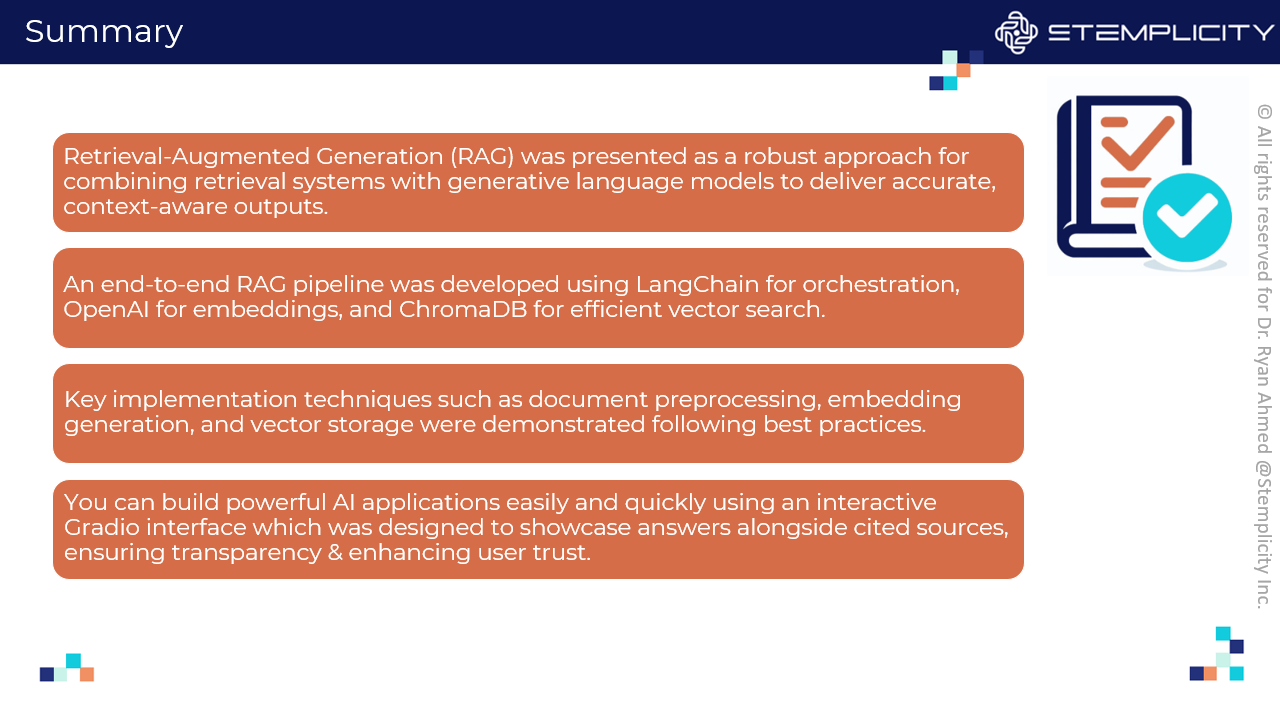

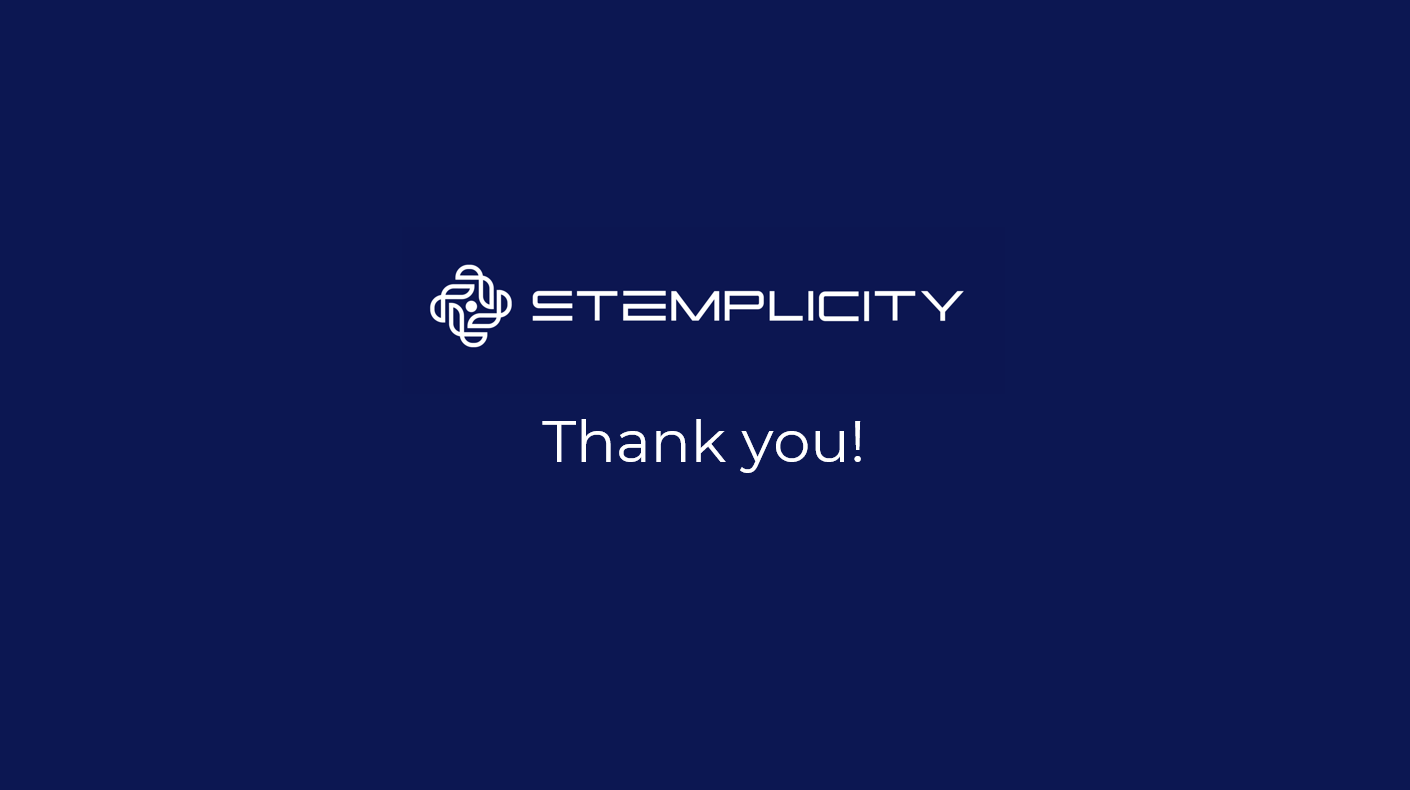